# User Latent Dirichlet Allocation

In [184]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
sys.path.append(os.path.abspath('../../vae_playground'))
sys.path.append(os.path.abspath('..'))

In [185]:
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans

import vae_playground.datasets as datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Data

In [186]:
DATASET_NAME = 'goi4_dp_small'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [187]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 631815 consumption profiles from 365 dates and 1731 users


In [188]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = torch.tensor(data, dtype=torch.float32).reshape(-1, 24)
    #circle shift the last dimension of X
    X = torch.cat([X[:,6:], X[:,:6]], dim=-1).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
else:
    X = torch.tensor(data, dtype=torch.float32).reshape(num_users, num_days, int(24/RESOLUTION), int(RESOLUTION)).sum(dim=-1)
dates, users = np.reshape(dates, (num_users, num_days)), np.reshape(users, (num_users, num_days))

In [189]:
# Remove users with all-zero consumption profiles
nonzero_user_mask = torch.sum(torch.all(X == 0, dim=2), dim=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = torch.sum(torch.any(X < 0, dim=2), dim=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask

Removing 4 users with all-zero consumption profiles
Removing 18 users with any-negative consumption profiles


In [190]:
X = X[user_mask]
dates, users = dates[user_mask], users[user_mask]
user_ids = user_ids[user_mask]

In [191]:
USER_SUBSAMPLE_RATE = 1
DAY_SUBSAMPLE_RATE = 1
X = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
num_users, num_days, num_features = X.shape
X = X.flatten(end_dim=1)
print(f"Number of (subsampled/filtered) users: {num_users}")
print(f"Number of (subsampled) days: {num_days}")
print(f"Number of (aggregated) features: {num_features}")

Number of (subsampled/filtered) users: 1709
Number of (subsampled) days: 365
Number of (aggregated) features: 24


In [192]:
nonzero_mean, nonzero_std = datasets.zero_preserved_log_stats(X)
X_norm = datasets.zero_preserved_log_normalize(X, nonzero_mean, nonzero_std).reshape(num_users, num_days, num_features)
dataset = datasets.UserDayDataset(X_norm)
X_flt = dataset.flatten_inputs
user_idx, day_idx = dataset.user_day_list[:,0], dataset.user_day_list[:,1]

In [193]:
df_plt = pd.DataFrame(torch.cat((X_flt, user_idx.unsqueeze(1), day_idx.unsqueeze(1)), dim=-1))
df_plt.columns = [f'feature_{i}' for i in range(num_features)] + ['user'] + ['day']

In [194]:
if num_users <= 100 and num_features == 2:
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='user', palette="Set1", alpha=.5)
    # move the legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='user', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [195]:
from sklearn.decomposition import *
pca = PCA(n_components=10)
X_pca = torch.tensor(pca.fit_transform(X_flt))

In [196]:
n_bins = 100
kmeans = KMeans(n_clusters=n_bins, random_state=RANDOM_SEED, init='k-means++', n_init='auto').fit(X_pca)

In [197]:
labels = kmeans.labels_
labels_onehot = np.zeros((len(labels), len(set(labels))))
labels_onehot[np.arange(len(labels)), labels] = 1
X_words = torch.tensor(labels_onehot).reshape(num_users, num_days, -1)

In [198]:
DOC_TYPE = "day"       # "day" or "user"

if DOC_TYPE == "day":
    X_document = X_words.sum(dim=0)
elif DOC_TYPE == "user":
    X_document = X_words.sum(dim=1)
else:
    raise ValueError(f"Invalid DOC_TYPE: {DOC_TYPE}")

num_docs, num_words = X_document.shape

In [199]:
if n_bins <= 50 and X_pca.shape[1] == 2:
    df_plt = pd.DataFrame(torch.cat((X_pca,torch.tensor(labels).unsqueeze(1)), dim=-1))
    df_plt.columns = [f'feature_{i}' for i in range(X_pca.shape[1])] + ['word']
    sns.scatterplot(df_plt, x="feature_0", y="feature_1", hue='word', palette="Set2", alpha=.5)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker='x', s=100, c='black')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='word_id', ncol=5)
    plt.xlabel('Diurnal consumption')
    plt.ylabel('Nocturnal consumption')
    plt.show()

In [200]:
X_labels = torch.tensor(labels).reshape(num_users, num_days)
if DOC_TYPE == "day": X_labels = X_labels.T

In [201]:
# Set training parameters.
num_topics = 50
alpha_prior = 1.0/num_topics
eta_prior = 1.0/num_topics
perp_tol = 1e-2
num_epochs = 100
batch_size = 32
verbose = True
learning_method = 'online'
evaluate_every = 5

In [202]:
model = LDA(n_components = num_topics,
            doc_topic_prior = alpha_prior,
            topic_word_prior = eta_prior,
            learning_method = learning_method,
            evaluate_every = evaluate_every,
            max_iter = num_epochs,
            batch_size = batch_size,
            perp_tol = perp_tol,
            verbose = verbose,
            random_state = RANDOM_SEED)


In [203]:
# Train the model using default partitioning choice 
model.fit(X_document)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100, perplexity: 71.9529
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 71.8279
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100, perplexity: 71.7894
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 71.7599
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100, perplexity: 71.7350
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
itera

LatentDirichletAllocation(batch_size=32, doc_topic_prior=0.02, evaluate_every=5,
                          learning_method='online', max_iter=100,
                          n_components=50, perp_tol=0.01, random_state=2112,
                          topic_word_prior=0.02, verbose=True)

In [204]:
lambda_document = torch.tensor(model.components_)

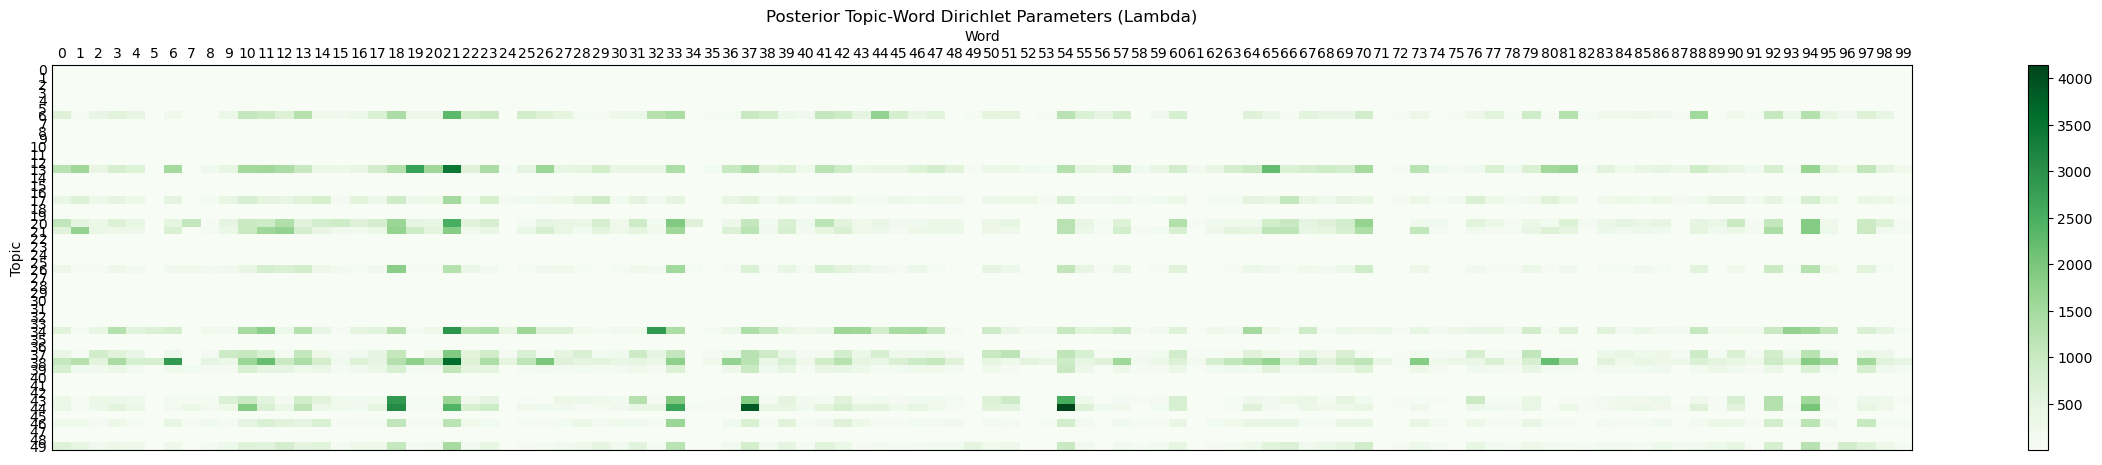

In [205]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(lambda_document, aspect='auto', cmap='Greens', interpolation='none')
ax.set_title('Posterior Topic-Word Dirichlet Parameters (Lambda)')
ax.set_ylabel('Topic')
ax.set_xlabel('Word')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(n_bins))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax)
plt.show()

In [206]:
gamma_document = torch.tensor(model.transform(X_document))*X_document.sum(1).reshape(-1,1).numpy()

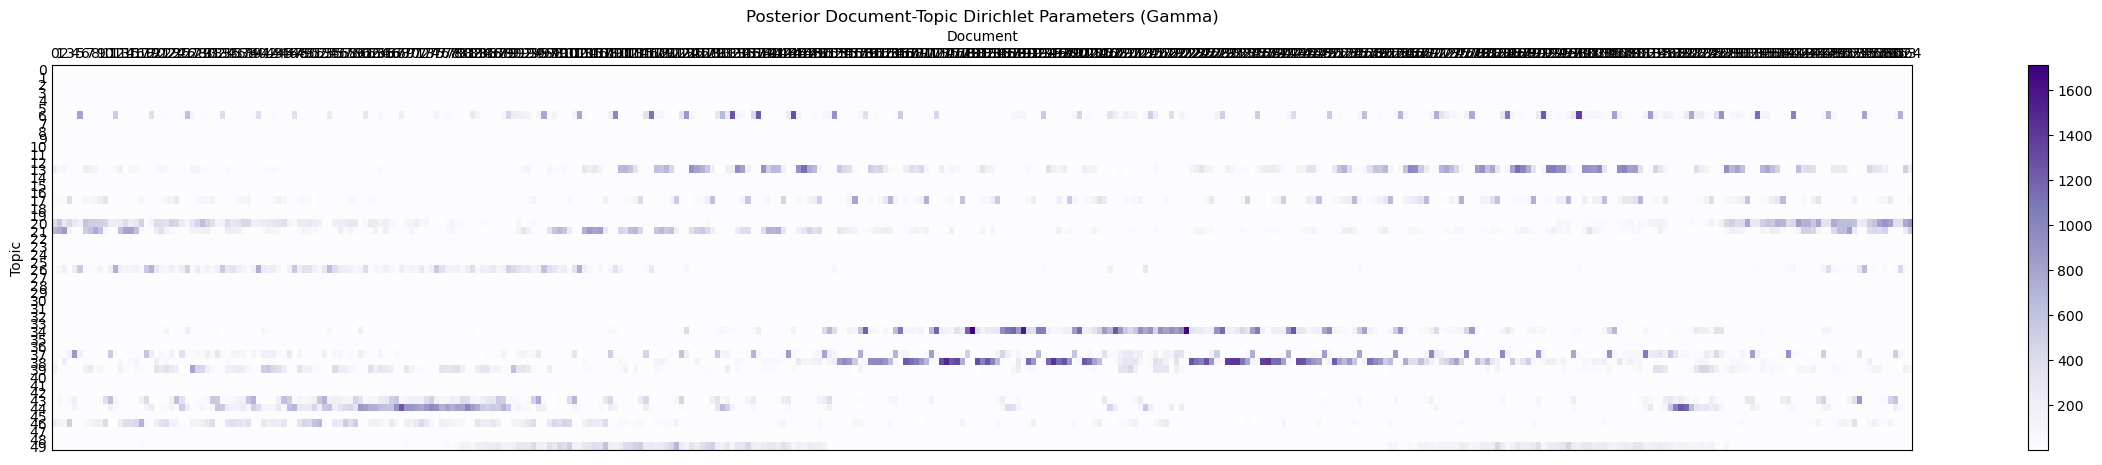

In [207]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(gamma_document.T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Posterior Document-Topic Dirichlet Parameters (Gamma)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(num_docs))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax)
plt.show()

In [208]:
from torch.special import digamma as torch_digamma

In [209]:
phi_document = torch.exp((torch_digamma(gamma_document) - torch_digamma(gamma_document.sum(1,keepdim=True))).unsqueeze(-1) + (torch_digamma(lambda_document) - torch_digamma(lambda_document.sum(1,keepdim=True))).unsqueeze(0))
phi_document = phi_document / phi_document.sum(1, keepdim=True)

In [210]:
DOCUMENT_NO = 55

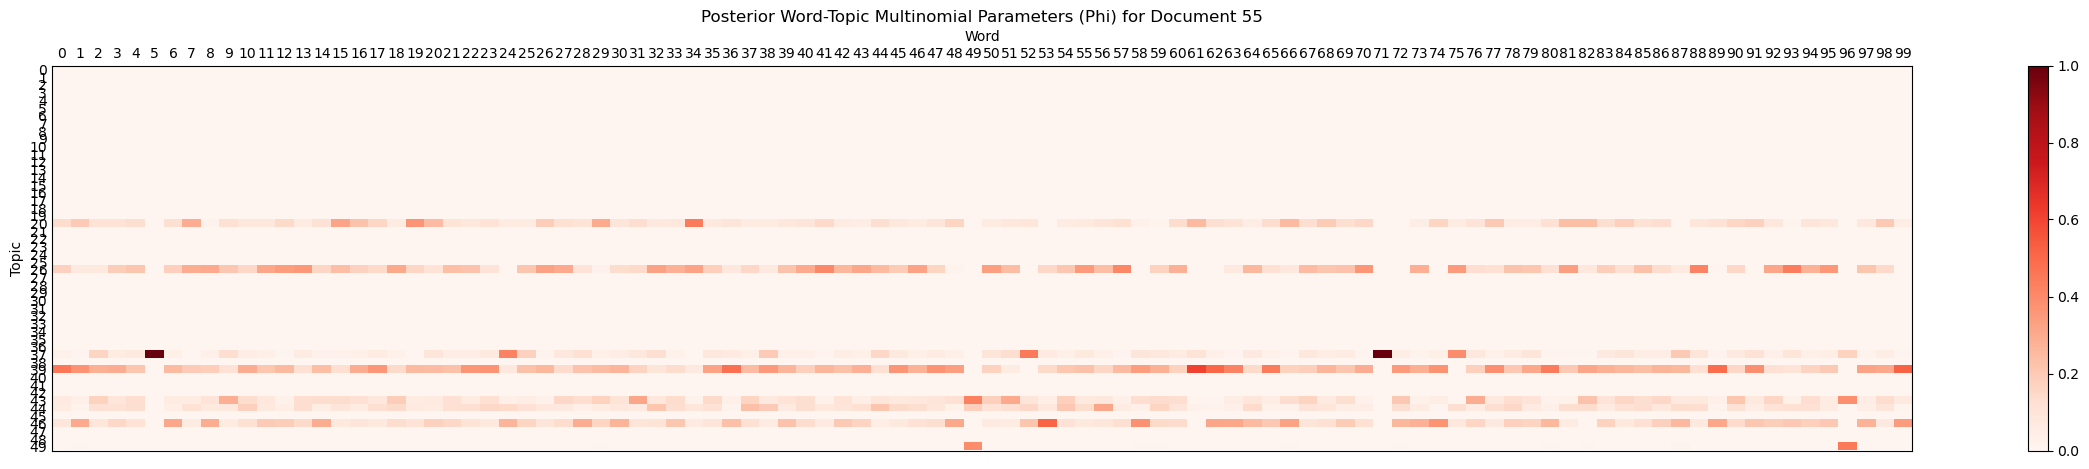

In [211]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(phi_document[DOCUMENT_NO], aspect='auto', cmap='Reds', interpolation='none')
ax.set_title(f'Posterior Word-Topic Multinomial Parameters (Phi) for Document {DOCUMENT_NO}')
ax.set_ylabel('Topic')
ax.set_xlabel('Word')
ax.set_yticks(np.arange(num_topics))
ax.set_xticks(np.arange(n_bins))
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
fig.colorbar(im, ax=ax)
plt.show()

In [212]:
beta_mean = lambda_document / lambda_document.sum(-1,keepdims=True)

In [213]:
gamma_document.shape

torch.Size([365, 50])

In [214]:
next_word_probs = (beta_mean.unsqueeze(0) * (gamma_document/gamma_document.sum(1,keepdims=True)).unsqueeze(-1)).sum(1)

<BarContainer object of 100 artists>

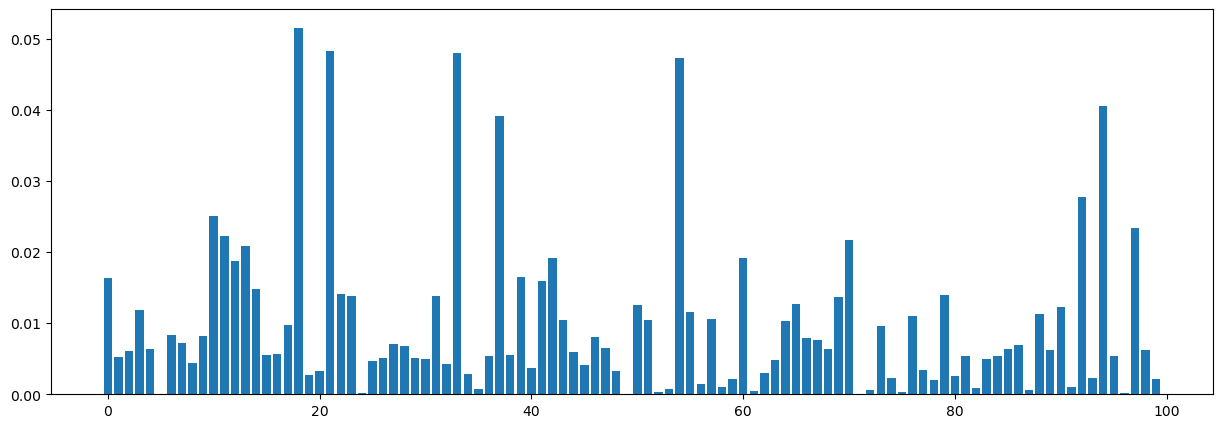

In [215]:
plt.bar(np.arange(n_bins), next_word_probs[DOCUMENT_NO], figure=plt.figure(figsize=(15,5)))

In [216]:
centers = datasets.zero_preserved_log_denormalize(torch.tensor(pca.inverse_transform(kmeans.cluster_centers_)), nonzero_mean, nonzero_std)

In [217]:
map_estimate = torch.argmax

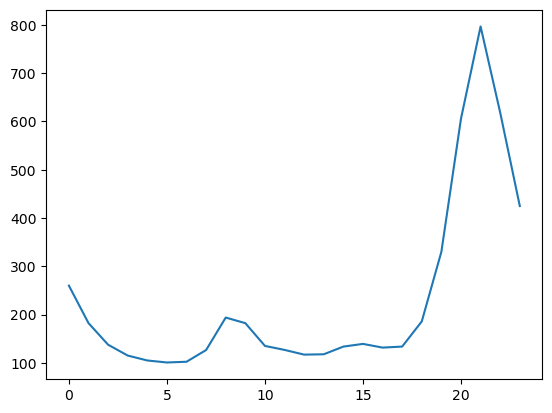

In [218]:
plt.plot(centers[map_estimate[DOCUMENT_NO]], label='MAP estimate')

<BarContainer object of 100 artists>

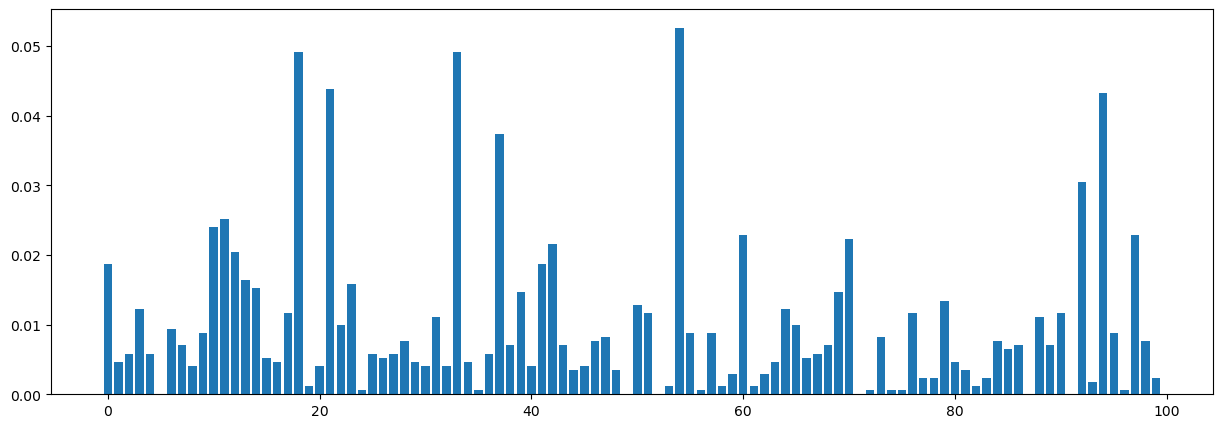

In [219]:
counts = X_document[DOCUMENT_NO]/X_document[DOCUMENT_NO].sum()
plt.bar(np.arange(n_bins), counts, figure=plt.figure(figsize=(15,5)))

In [220]:
freq_estimate = torch.argmax(counts)


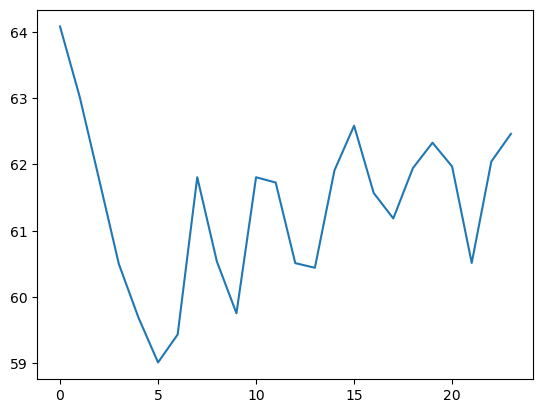

In [222]:
plt.plot(centers[freq_estimate], label='Frequency estimate')